# Hands-on Salmon

## Transcriptome

In this first section, we begin by defining a very simple transcriptome—a collection of RNA sequences that will serve as our model for testing RNA quantification.
Here’s what we’re doing step by step:

1. We use a Python dictionary called `transcripts_demo` to store our transcript sequences. In a real analysis, a transcriptome would include many transcripts, but for our demo we have just two keys: `"txA"` and `"txB"`. This structure makes it easy to access each transcript by its identifier.
2. Each key in the dictionary is associated with a string that represents the nucleotide sequence of that transcript. For simplicity, we have chosen arbitrary sequences. Notice that the sequences are repeated several times (multiplied by 10 for `"txA"` and by 15 for `"txB"`).
3. By limiting our dataset to just two transcripts, we keep the example straightforward and focused. This helps students understand the core concepts and code without being overwhelmed by the complexity of a full transcriptome.


In [1]:
# Suppose we have a tiny transcriptome of 2 transcripts
transcripts_demo = {
    "txA": "AGCGTACGTACTGACGTAGCTAGCTAGCGTACCGTTAGCA" * 10,
    "txB": "CGTACGGGTTTACGATCGATCGTAGCGTACGATCATTAACC" * 15,
}

## Biases

In building our generative model for RNA quantification, our goal is to simulate the way real RNA-seq experiments capture data. In actual experiments, several factors introduce biases in how reads are sampled from transcripts. By explicitly modeling these biases, we can generate synthetic data that more closely mirrors real-world scenarios, thereby allowing us to better test and understand the downstream quantification algorithms.

In practice, RNA-seq protocols do not sample uniformly along the entire length of a transcript. Often, fragments originating from the middle of a transcript are more likely to be sequenced, while those at the very beginning or end might be underrepresented. This can be due to biases in the fragmentation process or in the efficiency of reverse transcription.

**Why This Implementation?**

- By calculating the fraction of the transcript where the read begins, we normalize the position regardless of transcript length. This makes our function generally applicable.
- The exponential function `np.exp(-5.0 * (frac - 0.5) ** 2)` creates a bell-shaped curve centered around the midpoint (0.5). The constant `5.0` controls the sharpness of the decay, ensuring that positions near the ends are heavily penalized. This approach captures the idea that the likelihood of sampling a fragment drops off as you move away from the center.


In [2]:
def positional_bias_example(start_index, transcript_length):
    # fraction along the transcript
    frac = start_index / transcript_length
    # For instance, heavily penalize extremes:
    # near 0% => less likely, near 100% => less likely
    # peak in the middle
    return np.exp(-5.0 * (frac - 0.5) ** 2)

GC content plays a significant role in sequencing efficiency. Fragments with very low or very high GC content can be problematic during sequencing, resulting in their underrepresentation in the final dataset. Mid-range GC content, around 50%, is often optimal for many sequencing platforms.

**Why This Implementation?**

- Similar to the positional bias, this function uses an exponential decay centered around 0.5. This reflects the experimental observation that fragments with a GC fraction near 50% are sequenced more reliably.
- The exponential decay again provides a smooth, continuous way to reduce the likelihood of sampling fragments that deviate too far from the optimal GC content. This smooth curve is a reasonable approximation for the gradual decrease in sequencing efficiency observed in many studies.


In [3]:
def gc_bias_example(gc_frac):
    # Suppose we strongly favor mid-range GC
    return np.exp(-5 * (gc_frac - 0.5) ** 2)

The process of RNA fragmentation is not deterministic—fragments come in a variety of lengths. However, in many RNA-seq experiments, the distribution of fragment lengths follows a roughly normal distribution with a well-defined mean and standard deviation. Simulating this helps us mimic the natural variability in the data.

**Why This Implementation?**

- We choose a normal distribution centered at 150 nucleotides, a common fragment length in RNA-seq experiments, with a standard deviation of 30. This choice reflects typical experimental parameters and allows us to generate a realistic range of fragment lengths.
- The use of `max(25, ...)` ensures that the simulated fragments are not unrealistically short. In practical terms, fragments below a certain length (e.g., 25 nucleotides) would be excluded or handled differently in downstream analysis, so this constraint keeps our simulation within a meaningful range.


In [4]:
def frag_len_dist_example():
    # Use a normal distribution centered at 150 with standard deviation 30, but no shorter than 25.
    return max(25, int(np.random.default_rng().normal(150, 30)))

The function `simulate_rna_seq_reads` generates synthetic reads from a given set of transcripts using a generative model inspired by tools like Salmon.
The model integrates multiple factors—such as transcript abundance, fragment length variability, positional bias, and GC-content bias—to approximate real sequencing experiments.

In [ ]:
import numpy as np

def simulate_rna_seq_reads(
    transcripts: dict[str, str],
    alpha: list[int],
    num_reads: int = 10_000,
    frag_len_dist=None,
    pos_bias=None,
    gc_bias=None,
    rng=None,
) -> list[tuple[str, int, str]]:
    r"""
    Simulate reads according to a generative model similar to Salmon.

    Args:
        transcripts: A dictionary `{ transcript_id : transcript_sequence }`.
        alpha: Transcript abundance proportions (must sum to 1).
        num_reads: Total number of reads (fragments) to simulate.
        frag_len_dist: A function that samples from the chosen fragment length distribution.
            E.g. a lambda that calls np.random.  If None, we’ll assume a simple fixed length.
        pos_bias: Position bias function
        gc_bias: A function that, given GC content of a fragment, returns a multiplicative bias.
        rng: Random number generator for reproducibility. If None, a new default is created.

    Returns:
        A list of (transcript_id, start_pos, fragment_seq) for each simulated fragment.
    """
    # Seed the random number generator
    if rng is None:
        rng = np.random.default_rng()

    # Gather transcript IDs and sequences
    tx_ids: list[str] = list(transcripts.keys())
    tx_seqs = list(transcripts.values())
    M = len(tx_ids)

    # Basic checks
    alpha = np.array(alpha, dtype=float)
    alpha /= alpha.sum()

    # Default fragment length distribution if none is given
    if frag_len_dist is None:
        # Suppose we always sample fragments of length ~ 150 plus some noise
        def frag_len_dist():
            return max(25, int(rng.normal(150, 30)))

    reads = []

    # Precompute transcript lengths
    tx_lengths = np.array([len(seq) for seq in tx_seqs])

    # For each read to simulate:
    while len(reads) < num_reads:
        # 1. Choose a transcript index i ~ Multinomial(alpha)
        i = rng.choice(M, p=alpha)

        # 2. Sample fragment length
        L = frag_len_dist()

        # 3. Select a start position
        #    We'll ensure there's room for a fragment of length L
        max_start = max(0, tx_lengths[i] - L)
        if max_start == 0:
            # If the transcript is too short, skip or try smaller L
            # In a real simulator, you'd handle corner cases more gracefully.
            continue
        start = rng.integers(low=0, high=max_start + 1)

        # 4. Extract the fragment sequence from the transcript
        frag_seq = tx_seqs[i][start : start + L]

        # Initialize bias factor
        bias_factor = 1

        # 5. Compute positional bias
        if pos_bias:
            bias_factor *= pos_bias(start, len(tx_seqs[i]))

        # 6. Compute GC bias (entire fragment)
        if gc_bias:
            gc_frac = (frag_seq.count("G") + frag_seq.count("C")) / float(len(frag_seq))
            bias_factor *= gc_bias(gc_frac)

        # 7. Accept or reject fragment according to bias_factor.
        #    A typical generative approach would weight transcripts by bias_factor,
        #    but here we’ll do a simple “probabilistic acceptance” approach:
        #    e.g., if bias_factor < 0.5, we might reject half the time, etc.
        #    Or we can simply store the factor to re-weigh probabilities later.
        if rng.random() < bias_factor:
            # Store the read
            reads.append((tx_ids[i], int(start), frag_seq))

    return reads

In [7]:
import matplotlib.pyplot as plt


def plot_read_positions(transcripts, simulated_reads):
    """
    Create a matplotlib figure with two axes (one for each transcript in the demo).
    For each transcript, a solid horizontal line is plotted representing the transcript's full length.
    Then, each simulated read for that transcript is shown as a horizontal line underneath,
    offset by 0.5 for each read.

    Args:
    transcripts : dict[str, str]
        Dictionary mapping transcript IDs (e.g., "txA", "txB") to their sequences.
    simulated_reads : list of tuples
        Each tuple should be of the form (transcript_id, start_position, fragment_sequence).

    Returns
    -------
    fig : matplotlib.figure.Figure
        The generated figure.
    """
    # Create one subplot per transcript (assuming two transcripts: txA and txB)
    tx_ids = ["txA", "txB"]
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 8), sharex=False)

    for ax, tx in zip(axs, tx_ids):
        seq = transcripts[tx]
        tx_length = len(seq)
        # Draw the full transcript as a thick horizontal line at y=0.
        ax.hlines(
            y=0,
            xmin=0,
            xmax=tx_length,
            color="#03045e",
            linewidth=5,
            label="Transcript",
        )

        # Filter reads for the current transcript.
        tx_reads = [read for read in simulated_reads if read[0] == tx]

        # For each read, plot a horizontal line offset downward by 0.5 for each read.
        for i, (_, start, frag_seq) in enumerate(tx_reads):
            read_length = len(frag_seq)
            # Each read is drawn at y = -0.5*(i+1) (so they stack below the transcript)
            y_pos = -2 + -1.0 * (i + 1)
            ax.hlines(
                y=y_pos,
                xmin=start,
                xmax=start + read_length,
                color="#00b4d8",
                linewidth=2,
            )

        ax.set_title(f"Transcript {tx}")
        ax.set_xlim(0, tx_length)
        ax.set_yticks([])
        ax.set_ylim(-0.5 * (len(tx_reads) + 1), 1)
        ax.set_xlabel("Position along transcript")
        ax.set_ylabel("Reads")
        ax.invert_yaxis()

    plt.tight_layout()
    return fig

Simulated 200 reads.


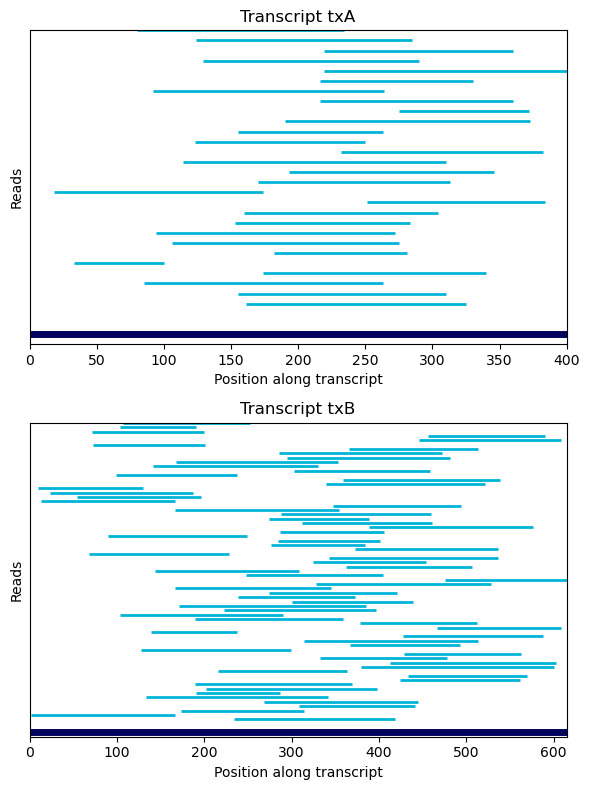

In [8]:
# initial transcript proportions
alpha_demo = [0.3, 0.7]

simulated_reads = simulate_rna_seq_reads(
    transcripts_demo,
    alpha_demo,
    num_reads=200,
    frag_len_dist=frag_len_dist_example,
    pos_bias=positional_bias_example,
    gc_bias=gc_bias_example,
)
print("Simulated {} reads.".format(len(simulated_reads)))

fig = plot_read_positions(transcripts_demo, simulated_reads)
plt.show()

In [9]:
from scipy.optimize import minimize


def estimate_effective_bias(
    transcripts: dict[str, str], frag_len_dist, pos_bias, gc_bias, n_samples=1000, rng=None
):
    """
    Estimate the effective bias factor p_i for each transcript i.

    The effective bias is computed by Monte Carlo sampling valid fragments from each transcript
    and averaging the product of the positional and GC bias.

    Parameters:
        transcripts : dict[str, str]
            Dictionary mapping transcript ID to sequence.
        frag_len_dist : function
            Function that returns an integer fragment length.
        pos_bias : Function (start, transcript_length) -> float.
        gc_bias : function
            Function (gc_frac) -> float.
        n_samples : int
            Number of Monte Carlo samples per transcript.
        rng : np.random.Generator, optional
            Random number generator.

    Returns:
        effective_bias : dict[str, float]
            Dictionary mapping transcript ID to effective bias p_i.
    """
    if rng is None:
        rng = np.random.default_rng()

    eff_bias = {}
    for tx_id, seq in transcripts.items():
        L_tx = len(seq)
        bias_values = []
        for _ in range(n_samples):
            L = frag_len_dist()
            # Only sample if the transcript is long enough for this fragment.
            if L >= L_tx:
                continue  # Skip this sample if transcript is too short.
            max_start = L_tx - L
            start = rng.integers(low=0, high=max_start + 1)
            frag_seq = seq[start : start + L]
            b = 1.0
            if pos_bias:
                b *= pos_bias(start, L_tx)
            if gc_bias:
                # Compute GC fraction in the fragment.
                gc_count = frag_seq.count("G") + frag_seq.count("C")
                gc_frac = gc_count / float(len(frag_seq))
                b *= gc_bias(gc_frac)
            bias_values.append(b)
        # If no valid fragments were sampled, set effective bias to 0.
        if bias_values:
            eff_bias[tx_id] = np.mean(bias_values)
        else:
            eff_bias[tx_id] = 0.0
    return eff_bias


In [10]:

def negative_log_likelihood(alpha, counts, effective_bias, tx_ids):
    """
    Compute the negative log likelihood given the candidate alpha.

    The predicted probability for transcript i is:
        p_i_pred = (alpha[i] * effective_bias[i]) / sum_j (alpha[j] * effective_bias[j])

    We assume the observed counts follow a multinomial distribution.

    Parameters:
        alpha : np.ndarray
            Candidate alpha vector (should sum to 1).
        counts : dict[str, int]
            Observed read counts for each transcript.
        effective_bias : dict[str, float]
            Effective bias factors for each transcript.
        tx_ids : list[str]
            Ordered list of transcript IDs.

    Returns:
        nll : float
            Negative log likelihood.
    """
    # Compute denominator: sum over transcripts
    numerators = np.array(
        [alpha[i] * effective_bias[tx_id] for i, tx_id in enumerate(tx_ids)]
    )
    denom = np.sum(numerators)
    if denom == 0:
        return np.inf
    # Compute predicted probabilities per transcript.
    p_pred = numerators / denom
    # Build observed frequency vector (using the order tx_ids).
    obs = np.array([counts.get(tx_id, 0) for tx_id in tx_ids])
    # To avoid log(0), add a small epsilon.
    epsilon = 1e-12
    nll = -np.sum(obs * np.log(p_pred + epsilon))
    return nll



In [11]:

def estimate_alpha(
    transcripts,
    simulated_reads,
    pos_bias,
    gc_bias,
    frag_len_dist,
    n_bias_samples=1000,
    rng=None,
):
    """
    Estimate the original alpha (transcript proportions) from simulated reads.

    Parameters:
        transcripts : dict[str, str]
            Dictionary of transcript sequences.
        simulated_reads : list of tuples
            Each tuple is (transcript_id, start_pos, fragment_seq).
        pos_bias : function
            Positional bias function.
        gc_bias : function
            GC bias function.
        frag_len_dist : function
            Function returning a fragment length.
        n_bias_samples : int
            Number of Monte Carlo samples per transcript for bias estimation.
        rng : np.random.Generator, optional
            Random number generator.

    Returns:
        est_alpha : dict[str, float]
            Estimated transcript proportions.
    """
    if rng is None:
        rng = np.random.default_rng()

    # 1. Count the number of reads per transcript.
    counts = {}
    for read in simulated_reads:
        tx_id = read[0]
        counts[tx_id] = counts.get(tx_id, 0) + 1

    tx_ids = list(transcripts.keys())
    M = len(tx_ids)

    # 2. Estimate effective bias factors for each transcript.
    effective_bias = estimate_effective_bias(
        transcripts, frag_len_dist, pos_bias, gc_bias, n_samples=n_bias_samples, rng=rng
    )

    # 3. Define the objective function for optimization.
    def objective(alpha_vec):
        return negative_log_likelihood(alpha_vec, counts, effective_bias, tx_ids)

    # 4. Initial guess: uniform distribution.
    x0 = np.ones(M) / M

    # Constraints: each alpha[i] >= 0 and sum(alpha) == 1.
    constraints = {"type": "eq", "fun": lambda a: np.sum(a) - 1}
    bounds = [(0, 1) for _ in range(M)]

    result = minimize(
        objective, x0, method="SLSQP", bounds=bounds, constraints=constraints
    )

    if not result.success:
        raise RuntimeError("Optimization failed: " + result.message)

    # 5. Map the estimated vector back to a dictionary.
    est_alpha = {tx_id: alpha for tx_id, alpha in zip(tx_ids, result.x)}
    return est_alpha


In [12]:

# Now estimate alpha given the simulated reads.
try:
    est_alpha = estimate_alpha(
        transcripts_demo,
        simulated_reads,
        frag_len_dist=frag_len_dist_example,
        pos_bias=positional_bias_example,
        gc_bias=gc_bias_example,
    )
    print("Estimated alphas:")
    for tx, a in est_alpha.items():
        print(f"  {tx}: {a:.4f}")
except RuntimeError as e:
    print("Optimization failed:", e)

Estimated alphas:
  txA: 0.3016
  txB: 0.6984
